# CNTK MNIST Example

In [10]:
import gzip
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os, os.path
import shutil
import struct
import sys

try:
    from urllib.request import urlretrieve
except ImportError:
    from urllib import urlretrieve

plt.ion()

## Download MNIST data

In [11]:
def loadData(gzfname):
    with gzip.open(gzfname) as gz:
        n = struct.unpack('I', gz.read(4))
        if n[0] != 0x3080000:
            raise Exception('Invalid file: unexpected magic number.')
        cimg = struct.unpack('>I', gz.read(4))[0]
        
        crow = struct.unpack('>I', gz.read(4))[0]
        ccol = struct.unpack('>I', gz.read(4))[0]
        if crow !=28 or ccol != 28:
            raise Exception('Invalid file: expected 28 rows/cols per image.')
        res = np.frombuffer(gz.read(cimg * crow * ccol), dtype = np.uint8)
        return res.reshape((cimg, crow * ccol))

def loadLabels(gzfname):
    with gzip.open(gzfname) as gz:
        n = struct.unpack('I', gz.read(4))
        if n[0] != 0x1080000:
            raise Exception('Invalid file: unexpected magic number.')
        cimg = struct.unpack('>I', gz.read(4))[0]
        res = np.frombuffer(gz.read(cimg), dtype=np.uint8)
        return res.reshape((cimg, 1))
    
def try_download(dirname):
    os.makedirs(dirname, exist_ok=True)
    base_addr = 'http://yann.lecun.com/exdb/mnist/'
    files = ['train-images-idx3-ubyte.gz','train-labels-idx1-ubyte.gz','t10k-images-idx3-ubyte.gz','t10k-labels-idx1-ubyte.gz']
    for fname in files:
        if not os.path.exists(os.path.join(dirname,fname)):
            print("Downloading "+base_addr+fname)
            urlretrieve(base_addr+fname, os.path.join(dirname,fname))
    train_data = loadData(os.path.join(dirname,files[0]))
    train_labels = loadLabels(os.path.join(dirname,files[1]))
    test_data = loadData(os.path.join(dirname,files[0]))
    test_labels = loadLabels(os.path.join(dirname,files[1]))
    return (train_data, train_labels, test_data, test_labels)
    

In [12]:
train_data, train_labels, test_data, test_labels = try_download('./MNIST-data')
train = np.hstack((train_data, train_labels))
test = np.hstack((test_data, test_labels))

## Visualize the data

Image Label:  3


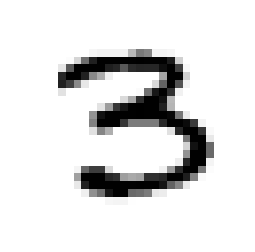

In [13]:
sample_number = np.random.randint(0, train.shape[0])
plt.imshow(train[sample_number,:-1].reshape(28,28), cmap="gray_r")
plt.axis('off')
print("Image Label: ", train[sample_number, -1])

## Save data files into a format compatible with CNTK text reader

In [14]:
def savetxt(filename, ndarray):
    dir = os.path.dirname(filename)
    if not os.path.exists(dir):
        os.makedirs(dir)
    
    print("Saving", filename)
    with open(filename, "w") as f:
        labels = list(map(' '.join, np.eye(10, dtype=np.uint).astype(str)))
        for row in ndarray:
            row_str = row.astype(str)
            label_str = labels[row[-1]]
            feature_str = ' '.join(row_str[:-1])
            f.write('|labels {} |features {}\n'.format(label_str, feature_str))

In [15]:
data_dir = "./MNIST-data"
savetxt(os.path.join(data_dir, "Train-28x28_cntk_text.txt"), train)
savetxt(os.path.join(data_dir, "Test-28x28_cntk_text.txt"), test)
print("Done.")

Saving ./MNIST-data\Train-28x28_cntk_text.txt
Saving ./MNIST-data\Test-28x28_cntk_text.txt


# Logistic Regression with MNIST

In [1]:
import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env()
C.cntk_py.set_fixed_random_seed(1) # fix the random seed so that LR examples are repeatable
input_dim = 784
num_output_classes = 10

train_file = "./MNIST-data/Train-28x28_cntk_text.txt"
test_file = "./MNIST-data/Test-28x28_cntk_text.txt"

In [8]:
def create_reader(path, is_training, input_dim, num_label_classes):
    """ Read a CTF formatted text using the CTF deserializer from a file"""
    labelStream = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False)
    featureStream = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
    deserializer = C.io.CTFDeserializer(path, C.io.StreamDefs(labels=labelStream, features=featureStream))
    return C.io.MinibatchSource(deserializer, randomize=is_training, max_sweeps=C.io.INFINITELY_REPEAT if is_training else 1)

## Logistic Regression nework setup

In [9]:
image = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform()):
        r = C.layers.Dense(num_output_classes, activation=None)(features)
        return r

# Scale the input ot 0-1 range by dividing each pixel by 255.
z = create_model(image/255.0)
loss = C.cross_entropy_with_softmax(z, label)
label_error = C.classification_error(z, label)

In [10]:
learning_rate = 0.2
lr_schedule = C.learning_parameter_schedule(learning_rate)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]  # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"
    
    if mb % frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose:
            print("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
    return mb, training_loss, eval_error        

## Run the trainer

In [11]:
minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

In [12]:
reader_train = create_reader(train_file, True, input_dim, num_output_classes)
input_map = {
    label: reader_train.streams.labels,
    image: reader_train.streams.features
}

training_progress_output_freq = 500

plotdata = {"batchsize":[], "loss":[], "error":[]}

for i in range(0, int(num_minibatches_to_train)):
    data = reader_train.next_minibatch(minibatch_size, input_map=input_map)
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    
    if not (loss == "NA" or error == "NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 2.2688, Error: 84.38%
Minibatch: 500, Loss: 0.2542, Error: 6.25%
Minibatch: 1000, Loss: 0.2631, Error: 3.12%
Minibatch: 1500, Loss: 0.4910, Error: 15.62%
Minibatch: 2000, Loss: 0.2292, Error: 7.81%
Minibatch: 2500, Loss: 0.1546, Error: 4.69%
Minibatch: 3000, Loss: 0.2870, Error: 7.81%
Minibatch: 3500, Loss: 0.2961, Error: 6.25%
Minibatch: 4000, Loss: 0.2764, Error: 3.12%
Minibatch: 4500, Loss: 0.2333, Error: 7.81%
Minibatch: 5000, Loss: 0.2287, Error: 6.25%
Minibatch: 5500, Loss: 0.1871, Error: 6.25%
Minibatch: 6000, Loss: 0.1601, Error: 3.12%
Minibatch: 6500, Loss: 0.2085, Error: 7.81%
Minibatch: 7000, Loss: 0.3106, Error: 9.38%
Minibatch: 7500, Loss: 0.2929, Error: 6.25%
Minibatch: 8000, Loss: 0.0857, Error: 0.00%
Minibatch: 8500, Loss: 0.1392, Error: 4.69%
Minibatch: 9000, Loss: 0.3307, Error: 9.38%


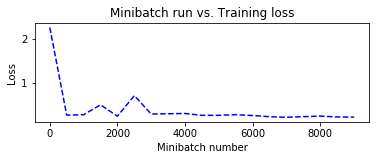

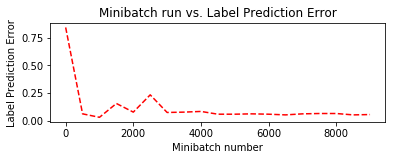

In [13]:
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')
plt.show()
plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

## Run evaluation / Testing

In [14]:
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label: reader_test.streams.labels,
    image: reader_test.streams.features,
}

test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    data = reader_test.next_minibatch(test_minibatch_size, input_map=test_input_map)
    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error

print("Average test error: {0:.2f}%".format(test_result*100/ num_minibatches_to_test))

Average test error: 7.01%


In [15]:
out = C.softmax(z)

In [17]:
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)

eval_minibatch_size = 25
# eval_input_map = { image: reader_eval.streams.features }

data = reader_test.next_minibatch(eval_minibatch_size, input_map = test_input_map)

img_label = data[label].asarray()
img_data = data[image].asarray()
predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]

print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [0, 9, 1, 2, 2, 9, 3, 6, 4, 8, 5, 8, 6, 3, 7, 7, 8, 5, 9, 2, 0, 7, 1, 2, 2]
Predicted: [0, 9, 1, 2, 2, 9, 3, 4, 4, 8, 5, 8, 6, 3, 7, 7, 8, 3, 9, 2, 0, 1, 1, 2, 2]


Image Label: 6, Predicted Label: 4


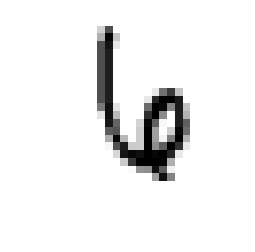

In [18]:
sample_number = 7
plt.imshow(img_data[sample_number].reshape(28,28), cmap='gray_r')
plt.axis('off')
img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: {0}, Predicted Label: {1}".format(img_gt, img_pred))

# Multi Layer Perceptron with MNIST

Relatively simple multi-layer perceptron model with 2 hidden layers.

In [14]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) # fix a random seed for CNTK components

input_dim = 784
num_output_classes = 10

num_hidden_layers = 2
hidden_layers_dim = 400

image = C.input_variable(input_dim)
label = C.input_variable(num_output_classes)

def create_model(features):
    with C.layers.default_options(init = C.layers.glorot_uniform(), activation = C.ops.relu):
        h = features
        for _ in range(num_hidden_layers):
            h = C.layers.Dense(hidden_layers_dim)(h)
        r = C.layers.Dense(num_output_classes, activation = None)(h)
        return r

z = create_model(image/255.0)

loss = C.cross_entropy_with_softmax(z, label)
label_error = C.classification_error(z, label)

In [15]:
learning_rate = 0.2
lr_schedule = C.learning_parameter_schedule(learning_rate)
learner = C.sgd(z.parameters, lr_schedule)
trainer = C.Trainer(z, (loss, label_error), [learner])

# Define a utility function to compute the moving average sum.
# A more efficient implementation is possible with np.cumsum() function
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]    # Need to send a copy of the array
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]


# Defines a utility that prints the training progress
def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"

    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose:
            print ("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))

    return mb, training_loss, eval_error

minibatch_size = 64
num_samples_per_sweep = 60000
num_sweeps_to_train_with = 10
num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size

train_file = "./MNIST-data/Train-28x28_cntk_text.txt"
test_file = "./MNIST-data/Test-28x28_cntk_text.txt"

def create_reader(path, is_training, input_dim, num_label_classes):
    return C.io.MinibatchSource(C.io.CTFDeserializer(path, C.io.StreamDefs(
        labels = C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
        features   = C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)
        )), randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

reader_train = create_reader(train_file, True, input_dim, num_output_classes)
input_map = {
    label: reader_train.streams.labels,
    image: reader_train.streams.features
}

training_progress_output_freq = 500
plotdata = {"batchsize":[], "loss":[], "error":[]}


for i in range(0, int(num_minibatches_to_train)):
    data = reader_train.next_minibatch(minibatch_size, input_map=input_map)
    trainer.train_minibatch(data)
    batchsize, loss, error = print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    if not (loss == "NA" or error == "NA"):
        plotdata["batchsize"].append(batchsize)
        plotdata["loss"].append(loss)
        plotdata["error"].append(error)

Minibatch: 0, Loss: 2.3311, Error: 95.31%
Minibatch: 500, Loss: 0.1621, Error: 6.25%
Minibatch: 1000, Loss: 0.0789, Error: 1.56%
Minibatch: 1500, Loss: 0.0659, Error: 3.12%
Minibatch: 2000, Loss: 0.0200, Error: 0.00%
Minibatch: 2500, Loss: 0.0134, Error: 0.00%
Minibatch: 3000, Loss: 0.0273, Error: 1.56%
Minibatch: 3500, Loss: 0.0723, Error: 4.69%
Minibatch: 4000, Loss: 0.0039, Error: 0.00%
Minibatch: 4500, Loss: 0.0612, Error: 1.56%
Minibatch: 5000, Loss: 0.0141, Error: 0.00%
Minibatch: 5500, Loss: 0.0257, Error: 1.56%
Minibatch: 6000, Loss: 0.0057, Error: 0.00%
Minibatch: 6500, Loss: 0.0064, Error: 0.00%
Minibatch: 7000, Loss: 0.0299, Error: 0.00%
Minibatch: 7500, Loss: 0.0118, Error: 0.00%
Minibatch: 8000, Loss: 0.0013, Error: 0.00%
Minibatch: 8500, Loss: 0.0052, Error: 0.00%
Minibatch: 9000, Loss: 0.0022, Error: 0.00%


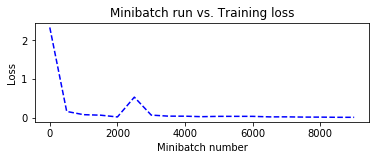

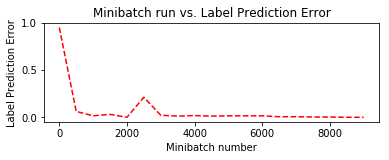

In [16]:
# Compute the moving average loss to smooth out the noise in SGD
plotdata["avgloss"] = moving_average(plotdata["loss"])
plotdata["avgerror"] = moving_average(plotdata["error"])

# Plot the training loss and the training error
import matplotlib.pyplot as plt

plt.figure(1)
plt.subplot(211)
plt.plot(plotdata["batchsize"], plotdata["avgloss"], 'b--')
plt.xlabel('Minibatch number')
plt.ylabel('Loss')
plt.title('Minibatch run vs. Training loss')

plt.show()

plt.subplot(212)
plt.plot(plotdata["batchsize"], plotdata["avgerror"], 'r--')
plt.xlabel('Minibatch number')
plt.ylabel('Label Prediction Error')
plt.title('Minibatch run vs. Label Prediction Error')
plt.show()

In [17]:
reader_test = create_reader(test_file, False, input_dim, num_output_classes)

test_input_map = {
    label: reader_test.streams.labels,
    image: reader_test.streams.features
}

test_minibatch_size = 512
num_samples = 10000
num_minibatches_to_test = num_samples // test_minibatch_size
test_result = 0.0

for i in range(num_minibatches_to_test):
    data = reader_test.next_minibatch(test_minibatch_size, input_map=test_input_map)
    eval_error = trainer.test_minibatch(data)
    test_result = test_result + eval_error
    
print("Average test error: {0:.2f}%".format(test_result*100/ num_minibatches_to_test))

Average test error: 0.05%


In [21]:
out = C.softmax(z)

eval_minibatch_size = 25

data = reader_test.next_minibatch(eval_minibatch_size, input_map=test_input_map)

img_label = data[label].asarray()
img_data = data[image].asarray()
predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_label))]

pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [3, 3, 2, 4, 8, 5, 9, 6, 3, 7, 7, 8, 0, 9, 8, 7, 8, 4, 1, 3, 6, 8, 5, 5, 6]
Predicted: [3, 3, 2, 4, 8, 5, 9, 6, 3, 7, 7, 8, 0, 9, 8, 7, 8, 4, 1, 3, 6, 8, 5, 5, 6]


Image Label: 5, Predicted Label: 5


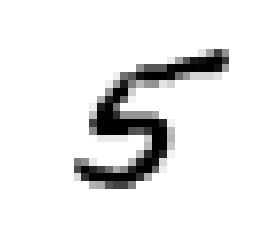

In [22]:
sample_number = 5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis("off")
img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Image Label: {0}, Predicted Label: {1}".format(img_gt, img_pred))

# Convolutional Neural Network with MNIST

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import time

import cntk as C
import cntk.tests.test_utils
cntk.tests.test_utils.set_device_from_pytest_env() # (only needed for our build system)
C.cntk_py.set_fixed_random_seed(1) 

plt.ion()

In [2]:
# Define the data dimensions
input_dim_model = (1, 28, 28)    # images are 28 x 28 with 1 channel of color (gray)
input_dim = 28*28                # used by readers to treat input data as a vector
num_output_classes = 10

def create_reader(path, is_training, input_dim, num_label_classes):

    ctf = C.io.CTFDeserializer(path, C.io.StreamDefs(
          labels=C.io.StreamDef(field='labels', shape=num_label_classes, is_sparse=False),
          features=C.io.StreamDef(field='features', shape=input_dim, is_sparse=False)))

    return C.io.MinibatchSource(ctf,
        randomize = is_training, max_sweeps = C.io.INFINITELY_REPEAT if is_training else 1)

train_file = "./MNIST-data/Train-28x28_cntk_text.txt"
test_file = "./MNIST-data/Test-28x28_cntk_text.txt"

# Create Model

In [3]:
x = C.input_variable(input_dim_model)
y = C.input_variable(num_output_classes)

def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.ops.relu):
        h = features
        h = C.layers.Convolution2D(filter_shape=(5,5),
                                  num_filters=8,
                                  strides=(2,2),
                                  pad=True,
                                  name='first_conv')(h)
        h = C.layers.Convolution2D(filter_shape=(5,5),
                                  num_filters=16,
                                  strides=(2,2),
                                  pad=True, name='second_conv')(h)
        r = C.layers.Dense(num_output_classes, activation=None, name='classify')(h)
        return r
    
z = create_model(x)

print("Output Shape of the first convoluation layer:", z.first_conv.shape)
print("Bias value of the last dense layer:", z.classify.b.value)
C.logging.log_number_of_parameters(z)

Output Shape of the first convoluation layer: (8, 14, 14)
Bias value of the last dense layer: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Training 11274 parameters in 6 parameter tensors.


In [17]:
def create_criterion_function(model, labels):
    loss = C.cross_entropy_with_softmax(model, labels)
    errs = C.classification_error(model, labels)
    return loss, errs
    
def moving_average(a, w=5):
    if len(a) < w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

def print_training_progress(trainer, mb, frequency, verbose=1):
    training_loss = "NA"
    eval_error = "NA"
    if mb%frequency == 0:
        training_loss = trainer.previous_minibatch_loss_average
        eval_error = trainer.previous_minibatch_evaluation_average
        if verbose:
            print("Minibatch: {0}, Loss: {1:.4f}, Error: {2:.2f}%".format(mb, training_loss, eval_error*100))
    return mb, training_loss, eval_error


## Configure training

In [20]:
def train_test(train_reader, test_reader, model_func, num_sweeps_to_train_with=10):
    model = model_func(x/255)
    loss, label_error = create_criterion_function(model, y)
    learning_rate = 0.2
    lr_schedule = C.learning_parameter_schedule(learning_rate)
    learner = C.sgd(z.parameters, lr_schedule)
    trainer = C.Trainer(z, (loss, label_error), [learner])
    minibatch_size =64
    num_samples_per_sweep = 60000
    num_minibatches_to_train = (num_samples_per_sweep * num_sweeps_to_train_with) / minibatch_size
    input_map = {
        y: train_reader.streams.labels,
        x: train_reader.streams.features
    }
    training_progress_output_freq = 500
    start = time.time()
    for i in range(0, int(num_minibatches_to_train)):
        data = train_reader.next_minibatch(minibatch_size, input_map=input_map)
        trainer.train_minibatch(data)
        print_training_progress(trainer, i, training_progress_output_freq, verbose=1)
    print("Training took {:.1f} sec".format(time.time() - start))
    
    test_input_map = {
        y: test_reader.streams.labels,
        x: test_reader.streams.features
    }
    
    test_minibatch_size = 512
    num_samples = 10000
    num_minibatches_to_test = num_samples // test_minibatch_size
    test_result = 0.0
    for i in range(num_minibatches_to_test):
        data = test_reader.next_minibatch(test_minibatch_size, input_map=test_input_map)
        eval_error = trainer.test_minibatch(data)
        test_result = test_result + eval_error
    print("Average test error: {0:.2f}%".format(test_result*100/num_minibatches_to_test))

In [21]:
def do_train_test():
    global z
    z = create_model(x)
    reader_train = create_reader(train_file, True, input_dim, num_output_classes)
    reader_test = create_reader(test_file, False, input_dim, num_output_classes)
    train_test(reader_train, reader_test, z)
    
do_train_test()

Minibatch: 0, Loss: 2.3093, Error: 89.06%
Minibatch: 500, Loss: 0.2153, Error: 7.81%
Minibatch: 1000, Loss: 0.1294, Error: 4.69%
Minibatch: 1500, Loss: 0.1101, Error: 3.12%
Minibatch: 2000, Loss: 0.0253, Error: 0.00%
Minibatch: 2500, Loss: 0.0037, Error: 0.00%
Minibatch: 3000, Loss: 0.0093, Error: 0.00%
Minibatch: 3500, Loss: 0.0481, Error: 1.56%
Minibatch: 4000, Loss: 0.0263, Error: 1.56%
Minibatch: 4500, Loss: 0.0394, Error: 1.56%
Minibatch: 5000, Loss: 0.0157, Error: 1.56%
Minibatch: 5500, Loss: 0.0020, Error: 0.00%
Minibatch: 6000, Loss: 0.0109, Error: 0.00%
Minibatch: 6500, Loss: 0.0199, Error: 0.00%
Minibatch: 7000, Loss: 0.0225, Error: 1.56%
Minibatch: 7500, Loss: 0.0020, Error: 0.00%
Minibatch: 8000, Loss: 0.0037, Error: 0.00%
Minibatch: 8500, Loss: 0.0112, Error: 0.00%
Minibatch: 9000, Loss: 0.0313, Error: 1.56%
Training took 7.6 sec
Average test error: 0.66%


In [22]:
print("Bias value of the last dense layer:", z.classify.b.value)

Bias value of the last dense layer: [-0.02220903 -0.04804248  0.07772575 -0.07995933 -0.02110142 -0.07236961
 -0.00538616 -0.1251514   0.25131276  0.0450375 ]


In [23]:
out = C.softmax(z)

In [27]:
reader_eval = create_reader(test_file, False, input_dim, num_output_classes)
eval_minibatch_size = 25
eval_input_map = {
    x: reader_eval.streams.features,
    y: reader_eval.streams.labels
}

data = reader_eval.next_minibatch(eval_minibatch_size, input_map=eval_input_map)

img_label = data[y].asarray()
img_data = data[x].asarray()

img_data = np.reshape(img_data, (eval_minibatch_size,1,28,28))

predicted_label_prob = [out.eval(img_data[i]) for i in range(len(img_data))]

pred = [np.argmax(predicted_label_prob[i]) for i in range(len(predicted_label_prob))]
gtlabel = [np.argmax(img_label[i]) for i in range(len(img_label))]
print("Label    :", gtlabel[:25])
print("Predicted:", pred)

Label    : [5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1]
Predicted: [5, 0, 4, 1, 9, 2, 1, 3, 1, 4, 3, 5, 3, 6, 1, 7, 2, 8, 6, 9, 4, 0, 9, 1, 1]


Predicted Label: 2, Image Label: 2


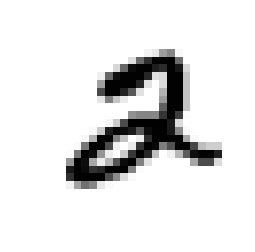

In [29]:
sample_number =5
plt.imshow(img_data[sample_number].reshape(28,28), cmap="gray_r")
plt.axis("off")
img_gt, img_pred = gtlabel[sample_number], pred[sample_number]
print("Predicted Label: {0}, Image Label: {1}".format(img_pred, img_gt))

In [34]:
def create_model(features):
    with C.layers.default_options(init=C.glorot_uniform(), activation=C.ops.relu):
        h = features
        h = C.layers.Convolution2D(filter_shape=(5,5,),
                                  num_filters=8,
                                  strides=(1,1),
                                  pad=True, name='first_conv')(h)
        h = C.layers.MaxPooling(filter_shape=(2,2),
                               strides=(2,2), name='fisrt_max')(h)
        h = C.layers.Convolution2D(filter_shape=(5,5),
                                 num_filters=16,
                                 strides=(1,1),
                                 pad=True, name="second_conv")(h)
        h = C.layers.MaxPooling(filter_shape=(3,3),
                               strides=(3,3), name="second_max")(h)
        r = C.layers.Dense(num_output_classes, activation=None, name="classify")(h)
        return r

z = create_model(x)
C.logging.log_number_of_parameters(z)
do_train_test()

Training 5994 parameters in 6 parameter tensors.
Minibatch: 0, Loss: 2.3725, Error: 89.06%
Minibatch: 500, Loss: 0.2003, Error: 10.94%
Minibatch: 1000, Loss: 0.1234, Error: 3.12%
Minibatch: 1500, Loss: 0.0400, Error: 1.56%
Minibatch: 2000, Loss: 0.0181, Error: 0.00%
Minibatch: 2500, Loss: 0.0212, Error: 1.56%
Minibatch: 3000, Loss: 0.0088, Error: 0.00%
Minibatch: 3500, Loss: 0.0558, Error: 1.56%
Minibatch: 4000, Loss: 0.0148, Error: 0.00%
Minibatch: 4500, Loss: 0.0262, Error: 1.56%
Minibatch: 5000, Loss: 0.0553, Error: 1.56%
Minibatch: 5500, Loss: 0.0022, Error: 0.00%
Minibatch: 6000, Loss: 0.0089, Error: 0.00%
Minibatch: 6500, Loss: 0.0179, Error: 0.00%
Minibatch: 7000, Loss: 0.0069, Error: 0.00%
Minibatch: 7500, Loss: 0.0047, Error: 0.00%
Minibatch: 8000, Loss: 0.0005, Error: 0.00%
Minibatch: 8500, Loss: 0.0137, Error: 0.00%
Minibatch: 9000, Loss: 0.0161, Error: 1.56%
Training took 8.2 sec
Average test error: 0.50%
